<a href="https://colab.research.google.com/github/andythetechnerd03/PyTorch_Learning/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

## 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Getting data

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

So our goals are:

* Performance - A model that performs at 95%+ accuracy.
* Speed - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

To try and achieve these results, let's bring in our best performing models from the previous sections:

1. **EffNetB2 feature extractor** (EffNetB2 for short) - originally created in 07. PyTorch Experiment Tracking section 7.5 using `torchvision.models.efficientnet_b2()` with adjusted `classifier` layers.
2. **ViT-B/16 feature extractor** (ViT for short) - originally created in 08. PyTorch Paper Replicating section 10 using `torchvision.models.vit_b_16()` with adjusted `head` layers.
  * Note ViT-B/16 stands for "Vision Transformer Base, patch size 16".

## 3. Creating an EffNetB2 feature extractor

In [5]:
# 1. Setup pretrained EffNMetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transform
effnetb2_transform = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers
for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

Change the classsifier to 3 classes

In [7]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3))

### 3.1. Creating a function to make an EffnetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes: int = 3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): Number of output neurons in the output layer. Defaults to 3
        seed (int, optional): Random seed value. Defaults to 42.

    Returns:
        torchvision.models.efficientnet_b2: EffNetB2 feature extractor model

    """
    # 1. Setup pretrained EffNMetB2 weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transform = effnetb2_weights.transforms()
    # 2. Setup pretrained model
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    # 3. Freeze the base layers
    for param in effnetb2.parameters():
        param.requires_grad = False

    # 4. Change the classsifier to 3 classes
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes))

    return effnetb2, effnetb2_transform

In [9]:
effnetb2, effnetb2_transform = create_effnetb2_model(num_classes=3,
                                                     seed=42)

In [10]:
from torchinfo import summary
summary(effnetb2, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2. Creating DataLoaders for EffNetB2

In [11]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transform,
    batch_size=32)

### 3.3. Training EffNetB2 feature extractor

In [12]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Setup seeds for reproducibility and train the model
set_seeds(seed=42)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5708 | test_loss: 0.7390 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6835 | train_acc: 0.8771 | test_loss: 0.5929 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5640 | train_acc: 0.8958 | test_loss: 0.4816 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4716 | train_acc: 0.8729 | test_loss: 0.4183 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.4308 | train_acc: 0.8729 | test_loss: 0.3723 | test_acc: 0.9659
Epoch: 6 | train_loss: 0.3738 | train_acc: 0.8979 | test_loss: 0.3456 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3373 | train_acc: 0.9062 | test_loss: 0.3132 | test_acc: 0.9568
Epoch: 8 | train_loss: 0.3248 | train_acc: 0.9250 | test_loss: 0.3009 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3671 | train_acc: 0.8562 | test_loss: 0.2747 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2564 | train_acc: 0.9458 | test_loss: 0.2649 | test_acc: 0.9597


### 3.4. Inspecting EffNetB2 loss curves

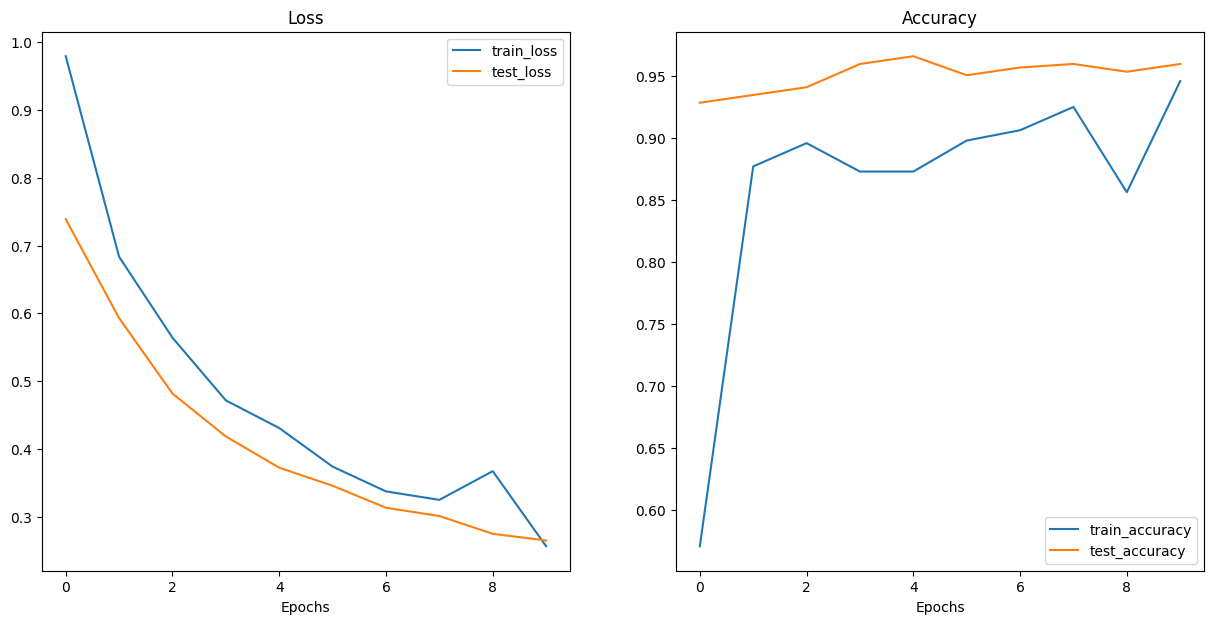

In [14]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5. Saving EffNetB2 feature extractor

In [15]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6. Checking the size of EffNetB2 feature extractor

In [16]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 / 1024
print(f"Model size: {pretrained_effnetb2_model_size:.2f} MB")

Model size: 29.86 MB


### 3.7. Collecting EffNetB2 feature extractor stats

We've got a few statistics about our EffNetB2 feature extractor model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

And we'll calculate an extra one for fun, total number of parameters.

We can do so by counting the number of elements (or patterns/weights) in `effnetb2.parameters()`. We'll access the number of elements in each parameter using the `torch.numel()` (short for "number of elements") method.

In [17]:
effnetb2_total_params = sum(torch.numel(t) for t in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2649004518985748,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model size (MB)': 29.85711097717285}

## 4. Creating a ViT feature extractor

In [19]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [20]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 81.7MB/s]


In [21]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1. Create DataLoaders for ViT

In [23]:
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### 4.2. Training ViT feature extractor

In [24]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0903 | train_acc: 0.9729 | test_loss: 0.0823 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9792 | test_loss: 0.0772 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9792 | test_loss: 0.0712 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0615 | train_acc: 0.9896 | test_loss: 0.0705 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9938 | test_loss: 0.0667 | test_acc: 0.9722


### 4.3. Inspecting ViT loss curves

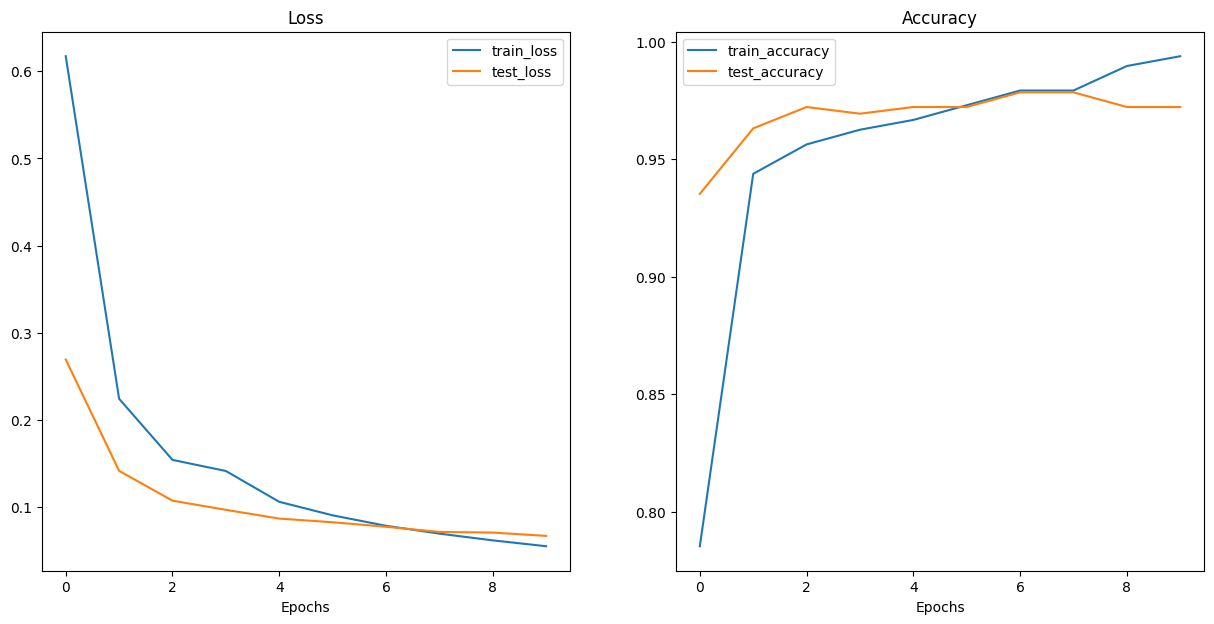

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4. Saving ViT feature extractor

In [26]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5. Checking the size of ViT feature extractor

In [27]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6. Collecting ViT feature extractor stats

In [28]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [29]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06667958875186741,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

In [30]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1844723.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3401466.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg')]

In [31]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2. Making and timing predictions with EffNetB2

We'll use CPU because it's more aligned with actual deployment (not always have access to GPU)

In [33]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transform,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.7327,
  'pred_class': 'sushi',
  'time_for_pred': 0.1559,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1844723.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8209,
  'pred_class': 'sushi',
  'time_for_pred': 0.1357,
  'correct': True}]

In [35]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.7327,sushi,0.1559,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8209,sushi,0.1357,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.8381,sushi,0.1184,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.7632,sushi,0.1451,True
4,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8916,sushi,0.1196,True


Beautiful!

In [36]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [37]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1344 seconds


In [38]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2649004518985748,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model size (MB)': 29.85711097717285,
 'time_per_pred_cpu': 0.1344}

### 5.3. Making and timing predictions with ViT

In [39]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9939,
  'pred_class': 'sushi',
  'time_for_pred': 0.9583,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1844723.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9875,
  'pred_class': 'sushi',
  'time_for_pred': 0.9129,
  'correct': True}]

In [41]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9939,sushi,0.9583,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9875,sushi,0.9129,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9606,sushi,0.6088,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9866,sushi,0.5971,True
4,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9949,sushi,0.6112,True


In [42]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [43]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.7106 seconds


In [44]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06667958875186741,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.7106}

## 6. Comparing model results, prediction times and size

In [45]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model size (MB),time_per_pred_cpu,model_size (MB),model
0,0.26490,95.97,7705221,29.857111,0.1344,NaN,EffNetB2
1,0.06668,97.22,85800963,NaN,0.7106,327.0,ViT


Let's see the ratio of difference.

In [46]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model size (MB),time_per_pred_cpu,model_size (MB)
ViT to EffNetB2 ratios,0.251716,1.013025,11.135432,NaN,5.287202,NaN


### 6.1. Visualizing the speed vs. performance tradeoff

ValueError: cannot convert float NaN to integer

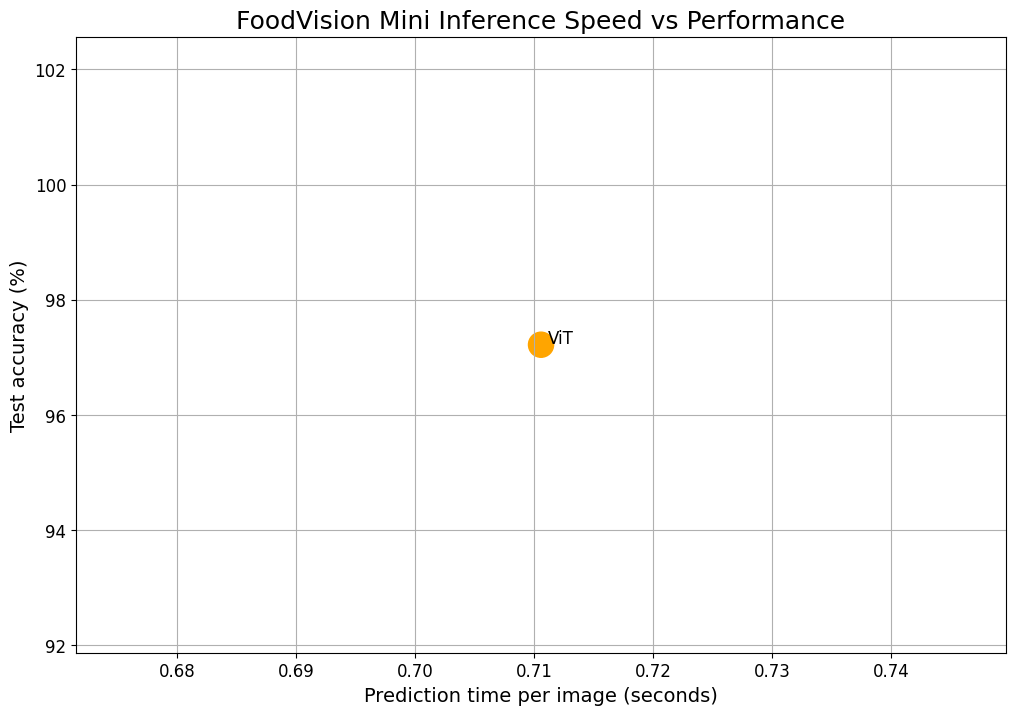

In [47]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
>

In [48]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.8 MB/s e

### 7.1. Gradio overview

### 7.2. Creating a function to map our inputs and outputs

In [49]:
# put EffNetB2 to CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device


device(type='cpu')

```
input image -> model -> (prediction probabilities, time)
```

Let's create a function called `predict()` to replicate the workflow above.

In [55]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transform(img).unsqueeze(0)

  # put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=-1)

  # Create a prediction label and predcition probability
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time and pred dict
  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time


In [56]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the random test image
random_image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the output
pred_labels_and_probs, pred_time = predict(random_image)
print(f"Prediction labels and probabilities: {pred_labels_and_probs}\n")
print(f"Prediction time: {pred_time}")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg

Prediction labels and probabilities: {'pizza': 0.05216221883893013, 'steak': 0.015308976173400879, 'sushi': 0.9325288534164429}

Prediction time: 0.12438


### 7.3. Creating a list of example images

Gradio's `Interface` class takes a list of examples of as an optional parameter (`gradio.Interface(examples=List[Any])`).

And the format for the examples parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

Three examples should be enough.

In [57]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg']]

### 7.4. Building a Gradio Interface

In [59]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7a90205b0217077133.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini into a deployable app

### 8.1. What is HuggingFace Spaces ?? (read yourself, fagg-it)

### 8.2. Deployed Gradio App Architecture

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

You can see this in action:
* Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3. Creating a `demos` folder to store our FoodVision app files

In [70]:
import shutil
from pathlib import Path

# Create FoodVision Mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

### 8.4. Creating a folder of example images to use with our FoodVision Mini Demo

What we want:
* 3 images in an `examples/` directory.
* Images should be from the test set.

In [71]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(example, destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory

In [72]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5. Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [73]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attemting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(effnetb2_foodvision_mini_model_path, effnetb2_foodvision_mini_model_destination)

  # Print a success message
  print(f"[INFO] Successfully moved {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

# If the model has already been moved, check if it exists
except FileNotFoundError:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attemting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: False


### 8.6. Turning off EffNetB2 model into a Python script (`model.py`)

We've saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [74]:
%%writefile demos/foodvision_mini/model.py
import torch, torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): Number of output neurons in the output layer. Defaults to 3
        seed (int, optional): Random seed value. Defaults to 42.

    Returns:
        torchvision.models.efficientnet_b2: EffNetB2 feature extractor model

    """
    # 1. Setup pretrained EffNMetB2 weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transform = effnetb2_weights.transforms()
    # 2. Setup pretrained model
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    # 3. Freeze the base layers
    for param in effnetb2.parameters():
        param.requires_grad = False

    # 4. Change the classsifier to 3 classes
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes))

    return effnetb2, effnetb2_transform

Writing demos/foodvision_mini/model.py


In [75]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transform = model.create_effnetb2_model()

### 8.7. Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup.
2. Model and transforms preparation.
3. `predict()` function.
4. Gradio app - Gradio Interface + launch command.

In [76]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, TypedDict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# Create EffNetB2 model instance and transform
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load model weights
effnetb2.load_state_dict(
    torch.load(
        os.path.join("models", "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"),
        map_location=torch.device("cpu")
        )
    )

# Predict function
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0)

  # put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=-1)

  # Create a prediction label and predcition probability
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(class_names)}

  # Calculate pred time and pred dict
  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

# Gradio app
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create an example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.inputs.Image(type="pil"),
                    outputs=[gr.outputs.Label(num_top_classes=3, label="Predictions"),
                             gr.outputs.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False,
            share=True)

Writing demos/foodvision_mini/app.py


### 8.8. Creating `requirements.txt`

* torch
* torchvision
* gradio

In [77]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

1. Uploading via the Hugging Face Web interface (easiest).
2. Uploading via the command line or terminal.
  * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.
Feel free to read the documentation on both options but we're going to go with option two.

>Note: To host anything on Hugging Face, you will to sign up for a free Hugging Face account.>

### 9.1. Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` app files

In [68]:
# Change into the foodvision_mini directory and compress it into a zip file
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


In [69]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download, please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2. Running our FoodVision Mini app locally

https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3. Uploading to HuggingFace Spaces

## 10. Creating FoodVision Big

### 10.1. Creating a model and transforms for FoodVision Big

In [78]:
# Create EffNetB2 model capable pf fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Let's get a summary of the model

In [79]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [80]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Let's create some advanced Data Augmentation - TrivialAugment

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [81]:
# Create Food101 transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])


In [82]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2. Getting data for FoodVision Big

In [84]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(data_dir, split="train",
                              download=True,
                              transform=food101_train_transforms)

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(data_dir, split="test",
                             download=True,
                             transform=effnetb2_transforms)

100%|██████████| 4996278331/4996278331 [04:33<00:00, 18261891.22it/s]


Extracting data/food-101.tar.gz to data


In [85]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3. Creating a subset of the Food101 dataset for faster experimenting

We don't need to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original Food101 paper's best results with only 20% of the data.

In [86]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths bases on the original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Split dataset into training and test sets
  random_split_1, random_split_2 = random_split(dataset, [length_1, length_2],
                                                generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [87]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [89]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4. Turning our Food101 datasets into `DataLoaders`

In [90]:
import torch
import os

BATCH_SIZE= 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5. Training FoodVision Big model